# Research Agent

Questo notebook implementa un agent di ricerca "semplice" utilizzando Langgraph e il nuovo modello cinese Deepseek-r1.


https://youtu.be/nRBiD_7l2Mg?si=DaE34157U7X1Hm8Y

Dal momento che la prima versione di deepseek-r1 non supporta i tools, utilizzo langraph per creare uno stateful agent.

L'iter del processo consiste nei seguenti step:
- l'utente inserisce una domanda o un argomento
- sulla base di questa domanda facciamo una ricerca su internet
- sulla base delle risposte ottenute viene restituito un summary all'utente



In [57]:
!ollama list

NAME                                  ID              SIZE      MODIFIED     
nomic-embed-text:latest               0a109f422b47    274 MB    3 days ago      
MFDoom/deepseek-r1-tool-calling:7b    2410129d448f    4.7 GB    5 days ago      
deepseek-r1:latest                    0a8c26691023    4.7 GB    6 days ago      
qwen2.5-coder:3b                      e7149271c296    1.9 GB    2 weeks ago     
sqlcoder:latest                       77ac14348387    4.1 GB    2 months ago    
llama3.2-vision:latest                38107a0cd119    7.9 GB    2 months ago    
llama3.2:3b-instruct-fp16             195a8c01d91e    6.4 GB    4 months ago    
llama3.2:latest                       a80c4f17acd5    2.0 GB    4 months ago    


In [58]:
from itertools import chain
from re import search

#import streamlit as st

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import START, END, StateGraph
from langchain_core.prompts import ChatPromptTemplate
from typing_extensions import TypedDict
import re

In [59]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["TAVILY_API_KEY"]

'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'

Definisco lo stato da condividere tra i diversi nodi del grafico. <br>
Questo stato viene passato a tutti i metodi (nodi) che costituiscono l'agent.

In [60]:
class ResearchState(TypedDict):
    query: str
    sources: list[str]
    web_results: list[str]
    summarized_results: list[str]
    response: str

Definisco anche l'input e l'output del graph. Questi contengono un sottoinsieme del contenuto dello stato

In [61]:
class ResearchStateInput(TypedDict):
    query: str

class ResearchStateOutput(TypedDict):
    sources: list[str]
    response: str

Definisco le diverse funzioni che costituiscono i nodi del graph. Ogni metodo riceve in input lo state e restituisce lo state stesso, arricchito con quanto prodotto dal metodo stesso. <br>

La prima funzione è quella che si occupa di fare la ricerca sul web utilizzando l'API Tavily. <br>
Riceve in input la query di ricerca dell'utente e restituisce nello stato:
- sources (gli url estratti dalla ricerca)
- il testo dei risultati della ricerca

In [62]:
def search_web(state: ResearchState):
    search = TavilySearchResults(max_results=3)
    search_results = search.invoke(state["query"])

    return  {
        "sources": [result['url'] for result in search_results],
        "web_results": [result['content'] for result in search_results]
    }


Questa funzione che riceve in input i risultati della ricerca e la query e, per ogni risultato di ricerca ne effettua il sommario e, dopo aver eliminato dalla risposta la sezione "di ragionamento" (tipica di deepseek-r1), concatena i risultati dei diversi sommari

In [63]:
summary_template = """
Summarize the following content into a concise paragraph that directly addresses the query. Ensure the summary 
highlights the key points relevant to the query while maintaining clarity and completeness.
Query: {query}
Content: {content}
"""

def summarize_results(state: ResearchState):
    model = ChatOllama(model="deepseek-r1")
    prompt = ChatPromptTemplate.from_template(summary_template)
    chain = prompt | model

    summarized_results = []
    for content in state["web_results"]:
        summary = chain.invoke({"query": state["query"], "content": content})
        clean_content = clean_text(summary.content)
        summarized_results.append(clean_content)

    return {
        "summarized_results": summarized_results
    }


def clean_text(text: str):
    cleaned_text = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)
    return cleaned_text.strip()

Funzione che riceve in input la concatenazione dei diversi sommari e la domanda iniziale e crea la risposta finale.

In [64]:
generate_response_template = """    
Given the following user query and content, generate a response that directly answers the query using relevant 
information from the content. Ensure that the response is clear, concise, and well-structured. 
Additionally, provide a brief summary of the key points from the response. 
Question: {question} 
Context: {context} 
Answer:
"""

def generate_response(state: ResearchState):
    model = ChatOllama(model="deepseek-r1")
    prompt = ChatPromptTemplate.from_template(generate_response_template)
    chain = prompt | model

    content = "\n\n".join([summary for summary in state["summarized_results"]])

    return {
        "response": chain.invoke({"question": state["query"], "context": content})
    }


Creo il grafico passando lo stato di input e output

In [65]:
builder = StateGraph(
    ResearchState,
    input=ResearchStateInput,
    output=ResearchStateOutput
)

In [66]:
builder.add_node("search_web", search_web)
builder.add_node("summarize_results", summarize_results)
builder.add_node("generate_response", generate_response)

builder.add_edge(START, "search_web")
builder.add_edge("search_web", "summarize_results")
builder.add_edge("summarize_results", "generate_response")
builder.add_edge("generate_response", END)

graph = builder.compile()

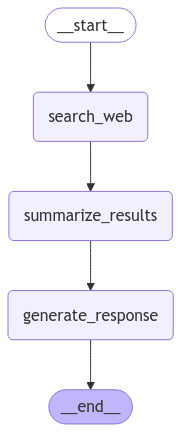

In [67]:
from langgraph.graph import StateGraph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [68]:
report_topic ="What are best place to visit in Rome?"
report=graph.invoke({"query":report_topic})
report

{'sources': ['https://www.rome.net/top-10',
  'https://www.earthtrekkers.com/best-things-to-do-in-rome/',
  'https://romesite.com/attractions.html'],
 'response': AIMessage(content="<think>\nAlright, let me tackle this query step by step. The user is asking about the best places to visit in Rome. I need to provide a clear, concise answer using relevant information from the provided context.\n\nFirst, looking at the content, there are several key locations highlighted:\n\n1. **Spanish Steps**: Located in Piazza di Spagna, it's a UNESCO site and one of Rome’s most desirable neighborhoods.\n2. **Sant'Agnese**: Known for its ancient catacombs, offering insight into Rome's past.\n3. **Altar of the Fatherland (Terminus de la Patrie)**: A terrace in Piazza di Spagna with panoramic views.\n4. **Piazza Venezia**: Features the Roman Forum and sites like Temple of Venus, Temples of Romulus and Antonius, hanging doors.\n5. **Santa Maria Maggiore**: Home to the High Altar and Nativity Crypt.\n6. **

In [72]:
report['sources']

['https://www.rome.net/top-10',
 'https://www.earthtrekkers.com/best-things-to-do-in-rome/',
 'https://romesite.com/attractions.html']

In [76]:
print(clean_text(report['response'].content))

### Best Places to Visit in Rome:

Rome is a city rich in history, culture, and landmarks, offering something for every type of visitor. Here are some of the top places to experience the city's timeless charm:

1. **Spanish Steps (Terminus de la Patrie)**  
   Located in the picturesque Piazza di Spagna, this terrace offers stunning views of Rome's skyline. It is a UNESCO World Heritage Site and one of the most desirable neighborhoods in the city.

2. **Sant'Agnese**  
   Known for its ancient catacombs, Sant'Agnese provides insight into Rome's past and is a significant spot for history enthusiasts.

3. **Piazza Venezia**  
   This vibrant square is home to the historic Roman Forum and features notable sites like the Temple of Venus, Temples of Romulus and Antonius, and the hanging doors.

4. **Santa Maria Maggiore**  
   This church is famous for its High Altar and Nativity Crypt, offering a glimpse into its rich religious history.

5. **San Pietro in Vincoli**  
   Another notable ch